<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [40]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation
from keras.optimizers import Adam
from tensorflow import keras

import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def extract_data_estruct3(file):
  data = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
  lead=[]
  mV=[]
  severity=[]
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_mvs = ecg_xml.getElementsByTagName('digits')
  for idx, ecg_leads_mv in enumerate(ecg_leads_mvs):
    if idx < 12:
      ecg_leads_mv = ecg_leads_mv.firstChild.data
      ecg_leads_mv = ecg_leads_mv.replace("\n","")
      ecg_leads_mv = ecg_leads_mv.replace("\t","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
      ecg_leads_mv2 = np.array(ecg_leads_mv,dtype=float)
      lead.append(idx)
      mV.append(ecg_leads_mv)
      severity = float(ecg_severity)
      data = data.append(pd.DataFrame({'lead':idx,'mV':[ecg_leads_mv2], 'severity':severity}), ignore_index=True)
  return data, lead, mV, severity

In [48]:
ecg_studies_e3 = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
lead=[]
mV=[]
severity=[]
for file in listdir('/content/ecg/'):
  if "fda" in file:
    data, lead_, mV_, severity_ = extract_data_estruct3('/content/ecg/'+file)
    lead.append(lead_)
    mV.append(mV_)
    severity.append(severity_)
    ecg_studies_e3 = ecg_studies_e3.append(data, ignore_index=True)

# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Severity:**

0 = estudio normal

1 = estudio fuera de lo normal

In [49]:
ecg_studies_e3

,lead,mV,severity
0,0.0,"[-3.0, -2.0, -2.0, -2.0, -3.0, -3.0, -3.0, -3....",1.0
1,1.0,"[-3.0, -2.0, -2.0, -4.0, -4.0, -4.0, -4.0, -4....",1.0
2,2.0,"[-1.0, 0.0, -1.0, -2.0, -1.0, -2.0, -2.0, -2.0...",1.0
3,3.0,"[4.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, ...",1.0
4,4.0,"[-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0...",1.0
...,...,...,...
79,7.0,"[43.0, 40.0, 40.0, 40.0, 41.0, 40.0, 39.0, 39....",1.0
80,8.0,"[42.0, 39.0, 39.0, 39.0, 42.0, 41.0, 40.0, 40....",1.0
81,9.0,"[-1.0, 0.0, -1.0, -2.0, -2.0, -3.0, -2.0, -3.0...",1.0
82,10.0,"[8.0, 7.0, 8.0, 6.0, 7.0, 7.0, 7.0, 6.0, 6.0, ...",1.0


# Ploting sample leads

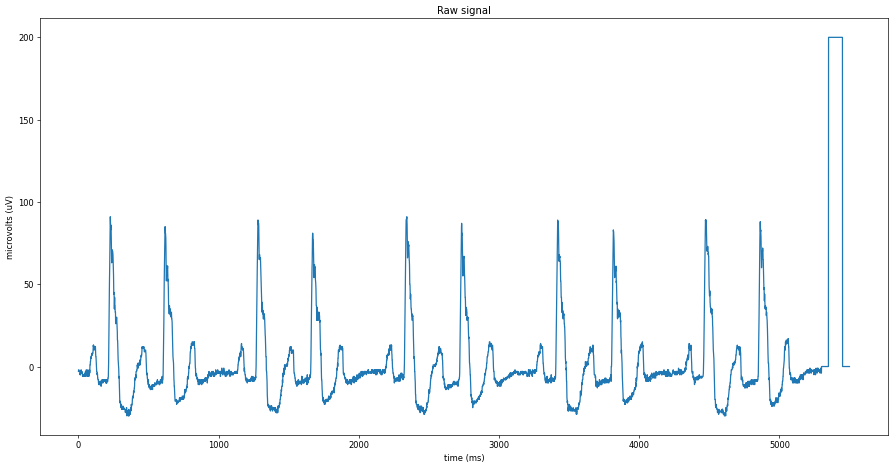

In [6]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

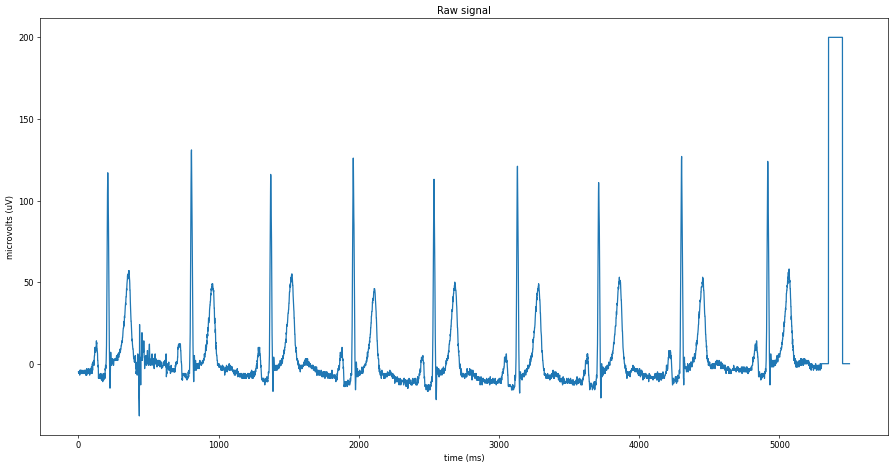

In [7]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[60])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

In [50]:
mV = np.array(mV, dtype=float)

# Data normalization

In [51]:
scaler = preprocessing.MinMaxScaler()
mV = scaler.fit_transform(mV.reshape(-1, mV.shape[-1])).reshape(mV.shape)

In [53]:
X = mV
y = np.array(severity, dtype=float)
y = y.reshape(-1,1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#train_size = int(len(mV) * 0.67)
#test_size = len(mV) - train_size
#train, test = mV[0:train_size,:], mV[train_size:len(mV),:]
print(len(X_train), len(X_test))
X_train.shape

4 3


(4, 12, 5500)

In [12]:
#X_train[:,0,:].reshape(1,X_train[:,0,:].size)


In [55]:
print(X.shape)
print(y.shape)

(7, 12, 5500)
(7, 1)


In [56]:
X_train[:,:1,:].shape


(4, 1, 5500)

In [57]:
X_train[:,0,:].shape[1]

5500

In [58]:
X_train.shape

(4, 12, 5500)

In [59]:
X_train[:,0,:].shape[1]

5500

# RNN LSTM building

In [65]:
lead_1_inp = Input((1,X_train[:,0,:].shape[1]))
lead_1_LSTM = LSTM(8, return_sequences=True)(lead_1_inp)
lead_1_LSTM = GlobalMaxPooling1D()(lead_1_LSTM)

lead_2_inp = Input((1,X_train[:,1,:].shape[1]))
lead_2_LSTM = LSTM(8, return_sequences=True)(lead_2_inp)
lead_2_LSTM = GlobalMaxPooling1D()(lead_2_LSTM)

lead_3_inp = Input((1,X_train[:,2,:].shape[1]))
lead_3_LSTM = LSTM(8, return_sequences=True)(lead_3_inp)
lead_3_LSTM = GlobalMaxPooling1D()(lead_3_LSTM)

lead_4_inp = Input((1,X_train[:,3,:].shape[1]))
lead_4_LSTM = LSTM(8, return_sequences=True)(lead_4_inp)
lead_4_LSTM = GlobalMaxPooling1D()(lead_4_LSTM)

lead_5_inp = Input((1,X_train[:,4,:].shape[1]))
lead_5_LSTM = LSTM(8, return_sequences=True)(lead_5_inp)
lead_5_LSTM = GlobalMaxPooling1D()(lead_5_LSTM)

lead_6_inp = Input((1,X_train[:,5,:].shape[1]))
lead_6_LSTM = LSTM(8, return_sequences=True)(lead_6_inp)
lead_6_LSTM = GlobalMaxPooling1D()(lead_6_LSTM)

lead_7_inp = Input((1,X_train[:,6,:].shape[1]))
lead_7_LSTM = LSTM(8, return_sequences=True)(lead_7_inp)
lead_7_LSTM = GlobalMaxPooling1D()(lead_7_LSTM)

lead_8_inp = Input((1,X_train[:,7,:].shape[1]))
lead_8_LSTM = LSTM(8, return_sequences=True)(lead_8_inp)
lead_8_LSTM = GlobalMaxPooling1D()(lead_8_LSTM)

lead_9_inp = Input((1,X_train[:,8,:].shape[1]))
lead_9_LSTM = LSTM(8, return_sequences=True)(lead_9_inp)
lead_9_LSTM = GlobalMaxPooling1D()(lead_9_LSTM)

lead_10_inp = Input((1,X_train[:,9,:].shape[1]))
lead_10_LSTM = LSTM(8, return_sequences=True)(lead_10_inp)
lead_10_LSTM = GlobalMaxPooling1D()(lead_10_LSTM)

lead_11_inp = Input((1,X_train[:,10,:].shape[1]))
lead_11_LSTM = LSTM(8, return_sequences=True)(lead_11_inp)
lead_11_LSTM = GlobalMaxPooling1D()(lead_11_LSTM)

lead_12_inp = Input((1,X_train[:,11,:].shape[1]))
lead_12_LSTM = LSTM(8, return_sequences=True)(lead_12_inp)
lead_12_LSTM = GlobalMaxPooling1D()(lead_12_LSTM)

In [75]:

concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])

h_1 = Dense(8)(concat)
h_1 = BatchNormalization()(h_1)
h_1 = Activation("tanh")(h_1)

o = Dense(2, activation="softmax")(h_1)

model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)

model.compile(optimizer="adam", loss='mean_squared_error', metrics=["accuracy"])
"""
h_1 = Dense(8)(lead_1_LSTM)
o = Dense(2, activation="softmax")(h_1)
model = Model(inputs =lead_1_inp, outputs = o)

model.compile(optimizer="adam", loss='mean_squared_error', metrics=["accuracy"])
"""

'\nh_1 = Dense(8)(lead_1_LSTM)\no = Dense(2, activation="softmax")(h_1)\nmodel = Model(inputs =lead_1_inp, outputs = o)\n\nmodel.compile(optimizer="adam", loss=\'mean_squared_error\', metrics=["accuracy"])\n'

In [76]:
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 5500)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1, 5500)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1, 5500)]    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 5500)]    0                                            
____________________________________________________________________________________________

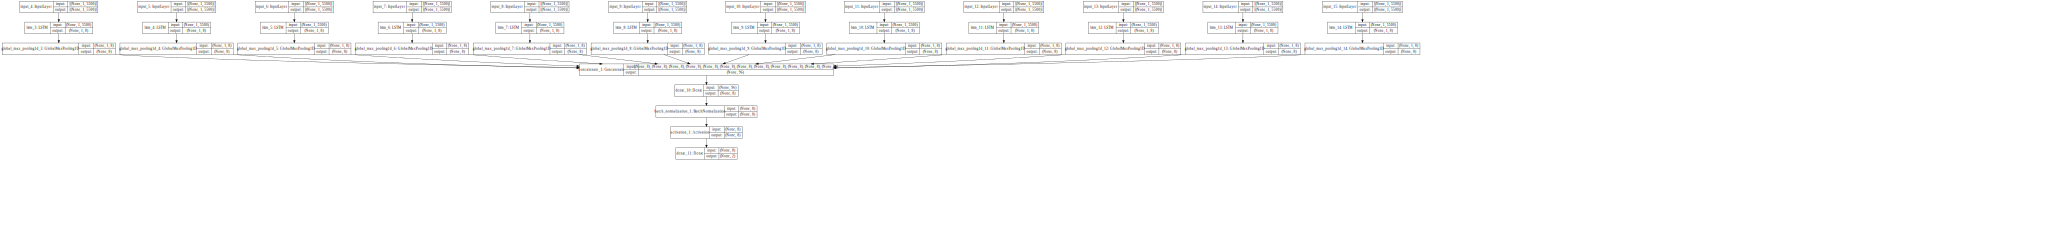

In [77]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [78]:
history = model.fit([X_train[:,:1,:], X_train[:,1:2,:], X_train[:,2:3,:], X_train[:,3:4,:], X_train[:,4:5,:], X_train[:,5:6,:], 
                     X_train[:,6:7,:], X_train[:,7:8,:], X_train[:,8:9,:], X_train[:,9:10,:], X_train[:,10:11,:], X_train[:,11:12,:]], 
                    y_train,epochs=20,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 0.2962 - accuracy: 0.3333 - val_loss: 0.2580 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 74ms/step - loss: 0.3125 - accuracy: 0.3333 - val_loss: 0.2578 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 73ms/step - loss: 0.2806 - accuracy: 0.6667 - val_loss: 0.2505 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 0.2651 - accuracy: 0.6667 - val_loss: 0.2631 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 71ms/step - loss: 0.2510 - accuracy: 0.6667 - val_loss: 0.2657 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 82ms/step - loss: 0.2529 - accuracy: 0.3333 - val_loss: 0.2625 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 84ms/step - loss: 0.2506 - accuracy: 0.3333 - val_loss: 0.2602 - val_accuracy: 1.0000
Epoch 8/20
1/1 [===